<a href="https://colab.research.google.com/github/amal-nj/Synthesia/blob/main/Synthesia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Synthesia
###AI Artathon
This notebook is composed of 3 different models and all the processing in between to produce the final output:
-	Timber transfer from Magnta/ddsp: source


#Timber transfer



In [1]:
#@title #Install and Import

#@markdown Install ddsp, define some helper functions, and download the model. This transfers a lot of data and _should take a minute or two_.
print('Installing from pip package...')
!pip install -qU ddsp==1.6.5

# Ignore a bunch of deprecation warnings
import warnings
warnings.filterwarnings("ignore")

import copy
import os
import time

import crepe
import ddsp
import ddsp.training
from ddsp.colab.colab_utils import (
    auto_tune, get_tuning_factor, download, 
    play, record, specplot, upload, 
    DEFAULT_SAMPLE_RATE)
from ddsp.training.postprocessing import (
    detect_notes, fit_quantile_transform
)
import gin
from google.colab import files
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pickle
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

# Helper Functions
sample_rate = DEFAULT_SAMPLE_RATE  # 16000


print('Done!')

Installing from pip package...
     |████████████████████████████████| 194 kB 5.2 MB/s 
     |████████████████████████████████| 4.0 MB 38.0 MB/s 
     |████████████████████████████████| 3.6 MB 44.7 MB/s 
     |████████████████████████████████| 210 kB 30.3 MB/s 
     |████████████████████████████████| 1.1 MB 70.5 MB/s 
     |████████████████████████████████| 87 kB 6.7 MB/s 
     |████████████████████████████████| 1.1 MB 68.2 MB/s 
     |████████████████████████████████| 64 kB 3.4 MB/s 
     |████████████████████████████████| 374 kB 59.1 MB/s 
     |████████████████████████████████| 20.2 MB 1.6 MB/s 
     |████████████████████████████████| 5.6 MB 21.5 MB/s 
     |████████████████████████████████| 51 kB 6.7 MB/s 
     |████████████████████████████████| 207 kB 56.5 MB/s 
Done!


Saving raise-me-up-first.mp3 to raise-me-up-first.mp3

Extracting audio features...


Audio features took 185.5 seconds


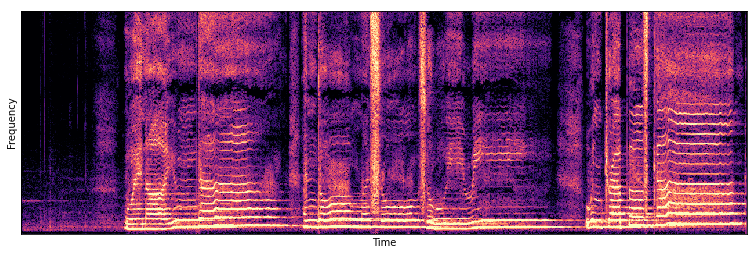

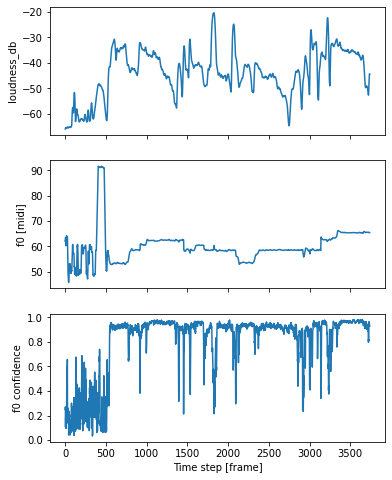

In [2]:
#@title Record or Upload Audio
#@markdown * Either record audio from microphone or upload audio from file (.mp3 or .wav) 
#@markdown * Audio should be monophonic (single instrument / voice)
#@markdown * Extracts fundmanetal frequency (f0) and loudness features. 

record_or_upload = "Upload (.mp3 or .wav)"  #@param ["Record", "Upload (.mp3 or .wav)"]

record_seconds =     5#@param {type:"number", min:1, max:10, step:1}

if record_or_upload == "Record":
  audio = record(seconds=record_seconds)
else:
  # Load audio sample here (.mp3 or .wav3 file)
  # Just use the first file.
  filenames, audios = upload()
  audio = audios[0]
if len(audio.shape) == 1:
  audio = audio[np.newaxis, :]
print('\nExtracting audio features...')

# Plot.
specplot(audio)
play(audio)

# Setup the session.
ddsp.spectral_ops.reset_crepe()

# Compute features.
start_time = time.time()
audio_features = ddsp.training.metrics.compute_audio_features(audio)
audio_features['loudness_db'] = audio_features['loudness_db'].astype(np.float32)
audio_features_mod = None
print('Audio features took %.1f seconds' % (time.time() - start_time))


TRIM = -15
# Plot Features.
fig, ax = plt.subplots(nrows=3, 
                       ncols=1, 
                       sharex=True,
                       figsize=(6, 8))
ax[0].plot(audio_features['loudness_db'][:TRIM])
ax[0].set_ylabel('loudness_db')

ax[1].plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax[1].set_ylabel('f0 [midi]')

ax[2].plot(audio_features['f0_confidence'][:TRIM])
ax[2].set_ylabel('f0 confidence')
_ = ax[2].set_xlabel('Time step [frame]')



In [3]:
#@title Load a model
#@markdown Run for ever new audio input
model = 'Flute' #@param ['Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone', 'Upload your own (checkpoint folder as .zip)']
MODEL = model


def find_model_dir(dir_name):
  # Iterate through directories until model directory is found
  for root, dirs, filenames in os.walk(dir_name):
    for filename in filenames:
      if filename.endswith(".gin") and not filename.startswith("."):
        model_dir = root
        break
  return model_dir 

if model in ('Violin', 'Flute', 'Flute2', 'Trumpet', 'Tenor_Saxophone'):
  # Pretrained models.
  PRETRAINED_DIR = '/content/pretrained'
  # Copy over from gs:// for faster loading.
  !rm -r $PRETRAINED_DIR &> /dev/null
  !mkdir $PRETRAINED_DIR &> /dev/null
  GCS_CKPT_DIR = 'gs://ddsp/models/timbre_transfer_colab/2021-07-08'
  model_dir = os.path.join(GCS_CKPT_DIR, 'solo_%s_ckpt' % model.lower())
  
  !gsutil cp $model_dir/* $PRETRAINED_DIR &> /dev/null
  model_dir = PRETRAINED_DIR
  gin_file = os.path.join(model_dir, 'operative_config-0.gin')

else:
  # User models.
  UPLOAD_DIR = '/content/uploaded'
  !mkdir $UPLOAD_DIR
  uploaded_files = files.upload()

  for fnames in uploaded_files.keys():
    print("Unzipping... {}".format(fnames))
    !unzip -o "/content/$fnames" -d $UPLOAD_DIR &> /dev/null
  model_dir = find_model_dir(UPLOAD_DIR)
  gin_file = os.path.join(model_dir, 'operative_config-0.gin')


# Load the dataset statistics.
DATASET_STATS = None
dataset_stats_file = os.path.join(model_dir, 'dataset_statistics.pkl')
print(f'Loading dataset statistics from {dataset_stats_file}')
try:
  if tf.io.gfile.exists(dataset_stats_file):
    with tf.io.gfile.GFile(dataset_stats_file, 'rb') as f:
      DATASET_STATS = pickle.load(f)
except Exception as err:
  print('Loading dataset statistics from pickle failed: {}.'.format(err))


# Parse gin config,
with gin.unlock_config():
  gin.parse_config_file(gin_file, skip_unknown=True)

# Assumes only one checkpoint in the folder, 'ckpt-[iter]`.
ckpt_files = [f for f in tf.io.gfile.listdir(model_dir) if 'ckpt' in f]
ckpt_name = ckpt_files[0].split('.')[0]
ckpt = os.path.join(model_dir, ckpt_name)

# Ensure dimensions and sampling rates are equal
time_steps_train = gin.query_parameter('F0LoudnessPreprocessor.time_steps')
n_samples_train = gin.query_parameter('Harmonic.n_samples')
hop_size = int(n_samples_train / time_steps_train)

time_steps = int(audio.shape[1] / hop_size)
n_samples = time_steps * hop_size

# print("===Trained model===")
# print("Time Steps", time_steps_train)
# print("Samples", n_samples_train)
# print("Hop Size", hop_size)
# print("\n===Resynthesis===")
# print("Time Steps", time_steps)
# print("Samples", n_samples)
# print('')

gin_params = [
    'Harmonic.n_samples = {}'.format(n_samples),
    'FilteredNoise.n_samples = {}'.format(n_samples),
    'F0LoudnessPreprocessor.time_steps = {}'.format(time_steps),
    'oscillator_bank.use_angular_cumsum = True',  # Avoids cumsum accumulation errors.
]

with gin.unlock_config():
  gin.parse_config(gin_params)


# Trim all input vectors to correct lengths 
for key in ['f0_hz', 'f0_confidence', 'loudness_db']:
  audio_features[key] = audio_features[key][:time_steps]
audio_features['audio'] = audio_features['audio'][:, :n_samples]


# Set up the model just to predict audio given new conditioning
model = ddsp.training.models.Autoencoder()
model.restore(ckpt)

# Build model by running a batch through it.
start_time = time.time()
_ = model(audio_features, training=False)
print('Restoring model took %.1f seconds' % (time.time() - start_time))

Loading dataset statistics from /content/pretrained/dataset_statistics.pkl
Restoring model took 8.3 seconds


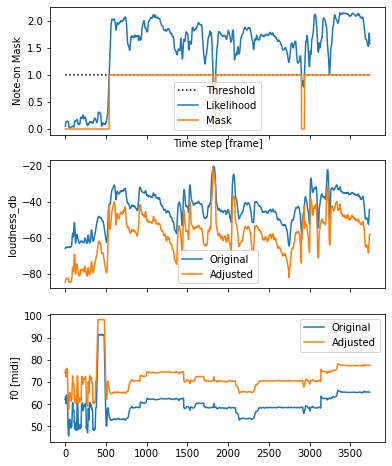

In [4]:
#@title Modify conditioning

#@markdown These models were not explicitly trained to perform timbre transfer, so they may sound unnatural if the incoming loudness and frequencies are very different then the training data (which will always be somewhat true). 


#@markdown ## Note Detection

#@markdown You can leave this at 1.0 for most cases
threshold = 1 #@param {type:"slider", min: 0.0, max:2.0, step:0.01}


#@markdown ## Automatic

ADJUST = True #@param{type:"boolean"}

#@markdown Quiet parts without notes detected (dB)
quiet = 20 #@param {type:"slider", min: 0, max:60, step:1}

#@markdown Force pitch to nearest note (amount)
autotune = 0 #@param {type:"slider", min: 0.0, max:1.0, step:0.1}

#@markdown ## Manual


#@markdown Shift the pitch (octaves)
pitch_shift =  -1 #@param {type:"slider", min:-2, max:2, step:1}

#@markdown Adjust the overall loudness (dB)
loudness_shift = 0 #@param {type:"slider", min:-20, max:20, step:1}


audio_features_mod = {k: v.copy() for k, v in audio_features.items()}


## Helper functions.
def shift_ld(audio_features, ld_shift=0.0):
  """Shift loudness by a number of ocatves."""
  audio_features['loudness_db'] += ld_shift
  return audio_features


def shift_f0(audio_features, pitch_shift=0.0):
  """Shift f0 by a number of ocatves."""
  audio_features['f0_hz'] *= 2.0 ** (pitch_shift)
  audio_features['f0_hz'] = np.clip(audio_features['f0_hz'], 
                                    0.0, 
                                    librosa.midi_to_hz(110.0))
  return audio_features


mask_on = None

if ADJUST and DATASET_STATS is not None:
  # Detect sections that are "on".
  mask_on, note_on_value = detect_notes(audio_features['loudness_db'],
                                        audio_features['f0_confidence'],
                                        threshold)

  if np.any(mask_on):
    # Shift the pitch register.
    target_mean_pitch = DATASET_STATS['mean_pitch']
    pitch = ddsp.core.hz_to_midi(audio_features['f0_hz'])
    mean_pitch = np.mean(pitch[mask_on])
    p_diff = target_mean_pitch - mean_pitch
    p_diff_octave = p_diff / 12.0
    round_fn = np.floor if p_diff_octave > 1.5 else np.ceil
    p_diff_octave = round_fn(p_diff_octave)
    audio_features_mod = shift_f0(audio_features_mod, p_diff_octave)


    # Quantile shift the note_on parts.
    _, loudness_norm = fit_quantile_transform(
        audio_features['loudness_db'],
        mask_on,
        inv_quantile=DATASET_STATS['quantile_transform'])

    # Turn down the note_off parts.
    mask_off = np.logical_not(mask_on)
    loudness_norm[mask_off] -=  quiet * (1.0 - note_on_value[mask_off][:, np.newaxis])
    loudness_norm = np.reshape(loudness_norm, audio_features['loudness_db'].shape)
    
    audio_features_mod['loudness_db'] = loudness_norm 

    # Auto-tune.
    if autotune:
      f0_midi = np.array(ddsp.core.hz_to_midi(audio_features_mod['f0_hz']))
      tuning_factor = get_tuning_factor(f0_midi, audio_features_mod['f0_confidence'], mask_on)
      f0_midi_at = auto_tune(f0_midi, tuning_factor, mask_on, amount=autotune)
      audio_features_mod['f0_hz'] = ddsp.core.midi_to_hz(f0_midi_at)

  else:
    print('\nSkipping auto-adjust (no notes detected or ADJUST box empty).')

else:
  print('\nSkipping auto-adujst (box not checked or no dataset statistics found).')

# Manual Shifts.
audio_features_mod = shift_ld(audio_features_mod, loudness_shift)
audio_features_mod = shift_f0(audio_features_mod, pitch_shift)



# Plot Features.
has_mask = int(mask_on is not None)
n_plots = 3 if has_mask else 2 
fig, axes = plt.subplots(nrows=n_plots, 
                      ncols=1, 
                      sharex=True,
                      figsize=(2*n_plots, 8))

if has_mask:
  ax = axes[0]
  ax.plot(np.ones_like(mask_on[:TRIM]) * threshold, 'k:')
  ax.plot(note_on_value[:TRIM])
  ax.plot(mask_on[:TRIM])
  ax.set_ylabel('Note-on Mask')
  ax.set_xlabel('Time step [frame]')
  ax.legend(['Threshold', 'Likelihood','Mask'])

ax = axes[0 + has_mask]
ax.plot(audio_features['loudness_db'][:TRIM])
ax.plot(audio_features_mod['loudness_db'][:TRIM])
ax.set_ylabel('loudness_db')
ax.legend(['Original','Adjusted'])

ax = axes[1 + has_mask]
ax.plot(librosa.hz_to_midi(audio_features['f0_hz'][:TRIM]))
ax.plot(librosa.hz_to_midi(audio_features_mod['f0_hz'][:TRIM]))
ax.set_ylabel('f0 [midi]')
_ = ax.legend(['Original','Adjusted'])


Prediction took 7.3 seconds
Original


Resynthesis


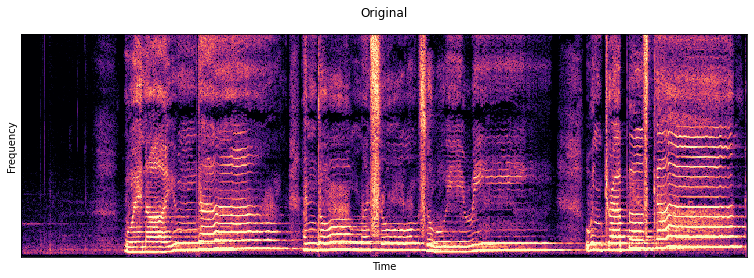

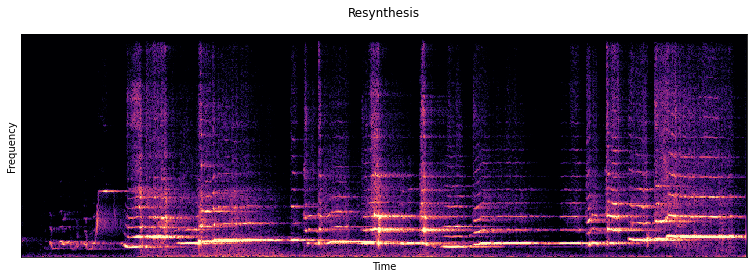

In [5]:
#@title #Resynthesize Audio

af = audio_features if audio_features_mod is None else audio_features_mod

# Run a batch of predictions.
start_time = time.time()
outputs = model(af, training=False)
audio_gen = model.get_audio_from_outputs(outputs)
print('Prediction took %.1f seconds' % (time.time() - start_time))

# Plot
print('Original')
play(audio)

print('Resynthesis')
play(audio_gen)

specplot(audio)
plt.title("Original")

specplot(audio_gen)
_ = plt.title("Resynthesis")

In [6]:
pip install pydub

In [8]:
pip install wavio

In [10]:
# import wavio as wv
# wv.write('/content/rainse-me-up-first-flute.mp2', audio_gen)

# Deep Visualizer

In [11]:
!git clone https://github.com/Ease78/deep-music-visualizer

%cd deep-music-visualizer

!pip install -r requirements.txt

Cloning into 'deep-music-visualizer'...
remote: Enumerating objects: 315, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 315 (delta 22), reused 2 (delta 1), pack-reused 267
Receiving objects: 100% (315/315), 11.15 MiB | 28.18 MiB/s, done.
Resolving deltas: 100% (122/122), done.
/content/deep-music-visualizer
     |████████████████████████████████| 31.2 MB 56 kB/s 
     |████████████████████████████████| 131 kB 61.4 MB/s 
     |████████████████████████████████| 79 kB 7.7 MB/s 
     |████████████████████████████████| 8.0 MB 47.4 MB/s 
     |████████████████████████████████| 138 kB 71.0 MB/s 
     |████████████████████████████████| 127 kB 54.5 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Success

In [13]:
!python visualize.py --song flute-raise-me-up-first.mp3 --resolution 256 --duration 3 --pitch_sensitivity 280 --tempo_sensitivity 0.8 --depth 0.3 --classes 985 979 978 973 966 960 889 614 594 568 536 420 --output_file flute-raise-me-up-first.mp4



Reading audio 

100% 234411737/234411737 [00:04<00:00, 47334937.72B/s]
100% 715/715 [00:00<00:00, 523007.91B/s]

Generating input vectors 

100% 647/647 [00:00<00:00, 908.30it/s]


Generating frames 

100% 4/4 [03:26<00:00, 51.73s/it]
[MoviePy] >>>> Building video flute-raise-me-up-first.mp4
[MoviePy] Writing audio in flute-raise-me-up-firstTEMP_MPY_wvf_snd.mp4
100% 67/67 [00:00<00:00, 337.77it/s]
[MoviePy] Done.
[MoviePy] Writing video flute-raise-me-up-first.mp4
100% 121/121 [00:00<00:00, 199.04it/s]
[MoviePy] Done.
[MoviePy] >>>> Video ready: flute-raise-me-up-first.mp4 



# Style Transfer

In [ ]:
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm

#@title Generate video using ffmpeg

init_frame =  1#@param  {type: "number"}
last_frame =  601#@param {type: "number"}
duration =  15#@param {type: "number"}

# min_fps =  30#@param {type: "number"}
# max_fps =  30#@param {type: "number"}

total_frames = last_frame-init_frame

min_fps =  (total_frames/duration)
max_fps =  min_fps
# Desired video runtime in seconds
length =  1#@param {type: "number"}
use_upscaled_images = False #@param {type: "boolean"}
frames = []
tqdm.write('Generating video...')


for i in range(init_frame,last_frame): #
  filename = f"/content/results/frame{i}.jpg"
  frames.append(Image.open(filename))

#fps = last_frame/10
fps = np.clip(total_frames/length,min_fps,max_fps)

# Names the video after the prompt if there is one, if not, defaults to video.mp4
def listToString(s): 
    
    # initialize an empty string
    str1 = "" 
    
    # traverse in the string  
    for ele in s: 
        str1 += ele  
    
    # return string  
    return str1 
        

video_filename = "flute-raise-me-up-first-2" #@param {type: "string"}
#@markdown Note: using images previously upscaled by ESRGAN may take longer to generate


video_filename = listToString(video_filename).replace(" ","_")
print("Video filename: "+ video_filename)

video_filename = video_filename + ".mp4"

from subprocess import Popen, PIPE
p = Popen(['ffmpeg', '-y', '-f', 'image2pipe', '-vcodec', 'png', '-r', str(fps), '-i', '-', '-vcodec', 'libx264', '-r', str(fps), '-pix_fmt', 'yuv420p', '-crf', '17', '-preset', 'veryslow', video_filename], stdin=PIPE)
for im in tqdm(frames):
    im.save(p.stdin, 'PNG')
p.stdin.close()

print("Compressing video...")
p.wait()

print("Video ready.")

Generating video...
Video filename: flute-raise-me-up-first


  0%|          | 0/600 [00:00<?, ?it/s]

Compressing video...
Video ready.


In [ ]:
def combine_audio(vidname, audname, outname, fps=25):
    import moviepy.editor as mpe
    my_clip = mpe.VideoFileClip(vidname)
    audio_background = mpe.AudioFileClip(audname)
    final_clip = my_clip.set_audio(audio_background)
    final_clip.write_videofile(outname,fps=fps)

In [ ]:
combine_audio(video_filename, "/content/flute-raise-me-up-first.mp3", "/flute-raise-me-up-first-audio.mp4", fps=min_fps)